# Inference and Attention Plots

# Library

In [1]:
import tensorflow as tf
import tensorflow_text
from pickle import load, dump
from time import time 
import numpy as np
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
import gc
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.10.1


# Load dataset

In [3]:
filename = '../data/deu-eng-test.pkl'
with open(filename, 'rb') as file:
    test_data = load(file)
type(test_data)    

numpy.ndarray

# Load Translator

In [4]:
translator = tf.saved_model.load('./metadata/translator_1')

In [5]:
def print_translation(sentence, tokens, ground_truth):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
    print(f'{"Ground truth":15s}: {ground_truth}')

In [6]:
test_data2 = np.array(test_data)
trainX = test_data2[:, 0]
trainY = test_data2[:, 1]
print(len(trainX))
for i in range(2000, 2005):
    # if i == 20: break
    sentence = trainX[i].decode('utf-8')
    ground_truth = trainY[i].decode('utf-8')
    translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
    print('\n')
    print_translation(sentence, translated_text, ground_truth)

26150


Input:         : Er war wütend auf seine Tochter.
Prediction     : he was angry with his daughter .
Ground truth   : He was angry with his daughter.


Input:         : Wie weit ist es bis zur Grenze?
Prediction     : how far is it to the to the to the to the to - chance ?
Ground truth   : How far away is the border?


Input:         : Fass nichts an, ohne zu fragen!
Prediction     : don ' t touch anything without asking .
Ground truth   : Don't touch anything without asking.


Input:         : Tom hasst es, beim Lernen gestört zu werden.
Prediction     : tom hates learning to be disturbed .
Ground truth   : Tom hates being disturbed when he's studying.


Input:         : Was hat Tom mitgebracht?
Prediction     : what did tom bring ?
Ground truth   : What did Tom bring with him?


# Attention Plots

In [7]:
sentence = "Fass nichts an, ohne zu fragen!"
ground_truth = "Don't touch anything without asking."
translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : Fass nichts an, ohne zu fragen!
Prediction     : don ' t touch anything without asking .
Ground truth   : Don't touch anything without asking.


## Load Tokenizer

Tokenization is the process of breaking up text, into "tokens". Depending on the tokenizer, these tokens can represent sentence-pieces, words, subwords, or characters. To learn more about tokenization, visit this guide.

This tutorial uses the tokenizers built in the subword tokenizer tutorial. That tutorial optimizes two text.BertTokenizer objects (one for English, one for Portuguese) for this dataset and exports them in a TensorFlow saved_model format.


In [8]:
tokenizers = tf.saved_model.load('./metadata/tokenizer_deu_eng')
string = "When writing a sentence, generally you start with a capital letter and finish with a period (.), an exclamation mark (!), or a question mark (?)."
tokens = tokenizers.eng.tokenize([string])
round_trip = tokenizers.eng.detokenize(tokens)
print(round_trip.numpy()[0].decode('utf-8'))


when writing a sentence , generally you start with a capital letter and finish with a period ( . ) , an exclamation mark ( ! ) , or a question mark ( ? ) .


In [9]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)
#   plt.show()

tf.Tensor(
[b'[START]' b'fass' b'nichts' b'an' b',' b'ohne' b'zu' b'fragen' b'!'
 b'[END]'], shape=(10,), dtype=string)
tf.Tensor(
[b'[START]' b'don' b"'" b't' b'touch' b'anything' b'without' b'asking'
 b'.' b'[END]'], shape=(10,), dtype=string)


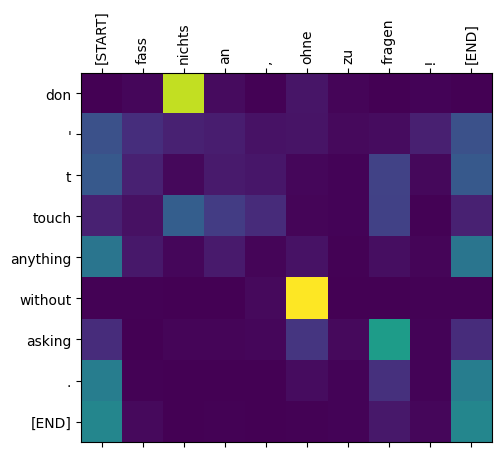

In [10]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape


in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.deu.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.deu.lookup(in_tokens)[0]
print(in_tokens)

print(translated_tokens)

plot_attention_head(in_tokens, translated_tokens, attention)

In [11]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.deu.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.deu.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

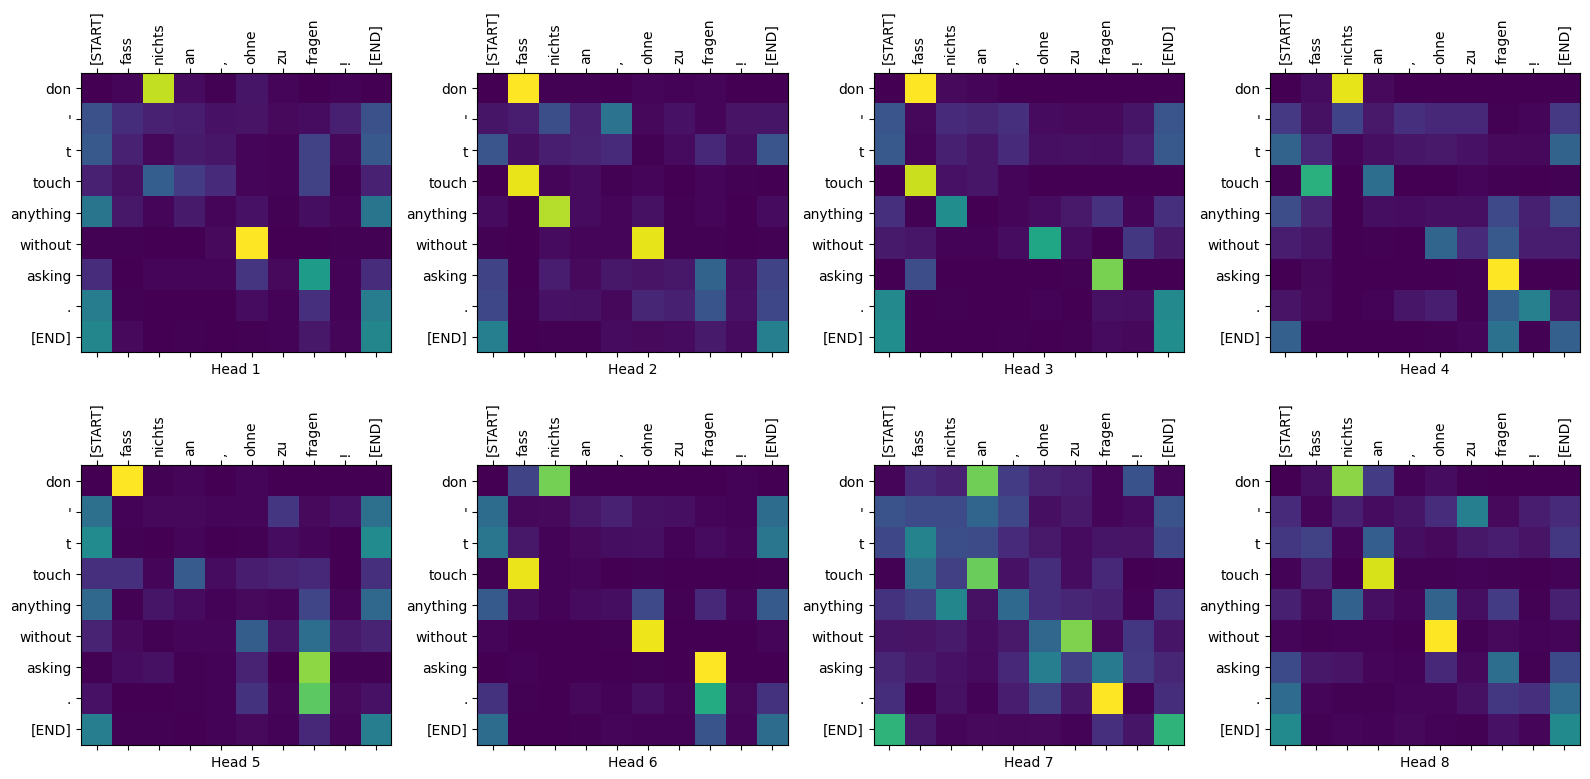

In [12]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])

Input:         : Er war wütend auf seine Tochter.
Prediction     : he was angry with his daughter .
Ground truth   : He was angry with his daughter.


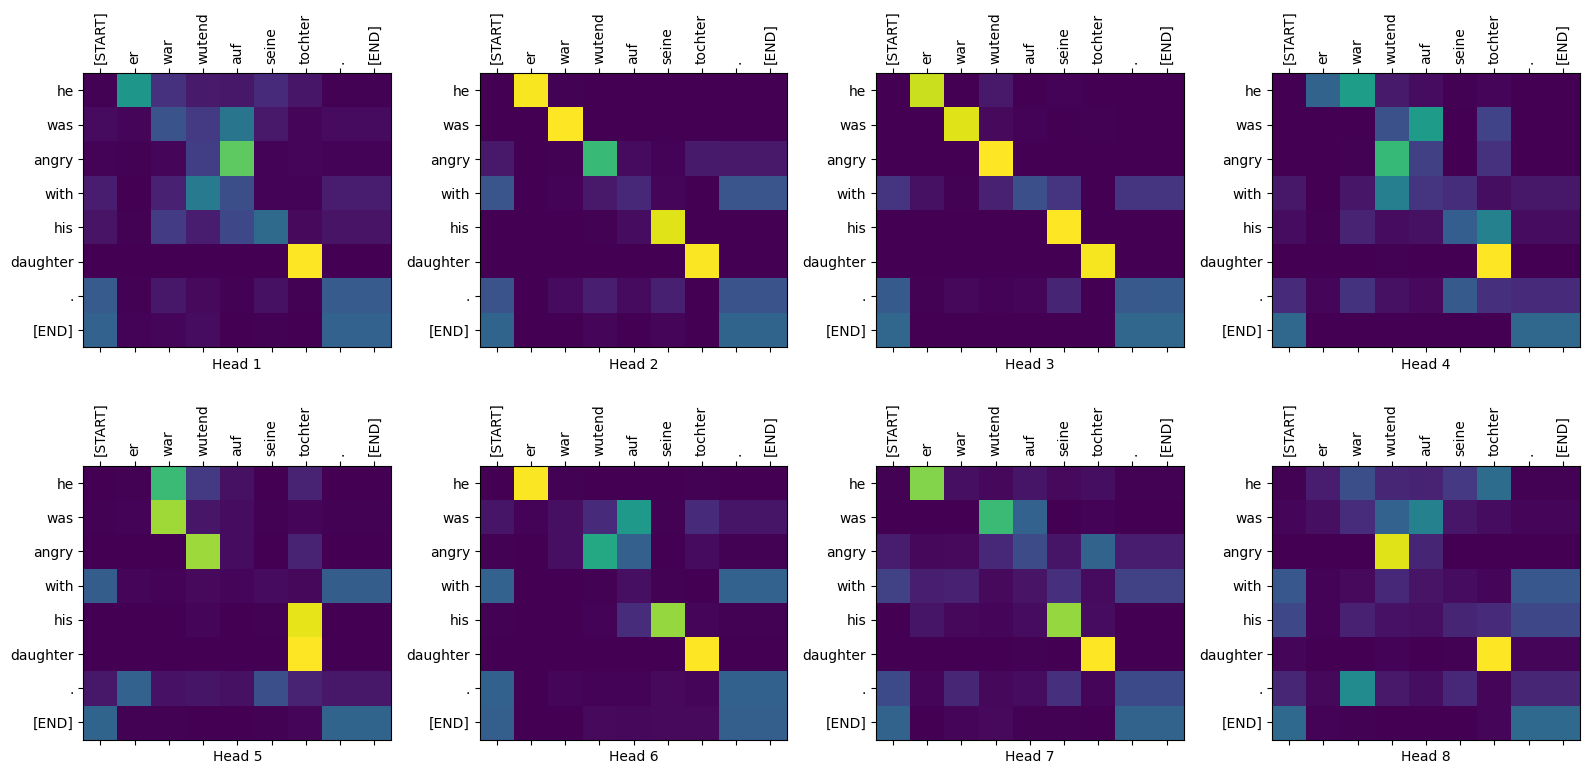

In [13]:
sentence = 'Er war wütend auf seine Tochter.'
ground_truth = 'He was angry with his daughter.'

translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)
plot_attention_weights(sentence, translated_tokens, attention_weights[0])